# Hamiltonian Monte Carlo

In [6]:
import Pkg
Pkg.add("ForwardDiff")
Pkg.add("Plots")

   Resolving package versions...
  No Changes to `C:\Users\Samue\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\Samue\.julia\environments\v1.6\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Samue\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\Samue\.julia\environments\v1.6\Manifest.toml`


In [9]:
using Random, Distributions, LinearAlgebra, ForwardDiff, Plots
Random.seed!(123)

MersenneTwister(123)

In [11]:
function π(θ)
    exp(-1/2 *  (prod(θ)^2 + sum(θ.^2) - 8 * sum(θ)) )
end

π (generic function with 1 method)

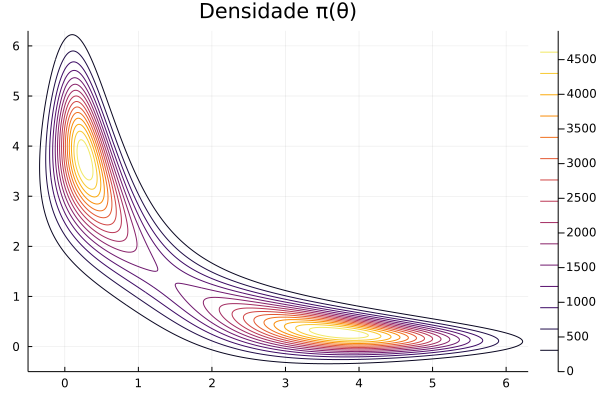

In [19]:
x = -0.5:0.01:6.3;
y = -0.5:0.01:6.3;
contour(x, y, (x,y) -> π((x,y)), title="Densidade π(θ)")

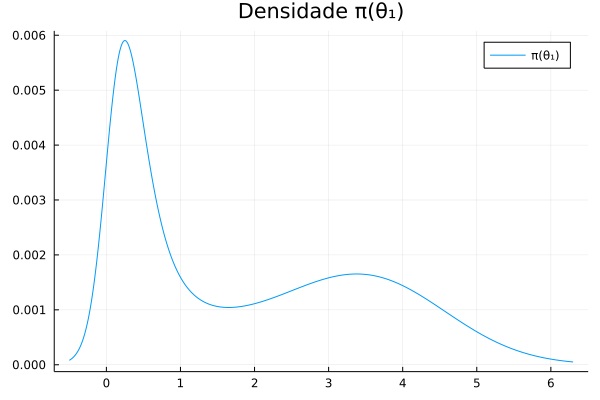

In [20]:
Z = zeros(size(x)[1], size(y)[1])
for (i, u) in enumerate(x)
    for (j, v) in enumerate(y)
        Z[i,j] = π([u,v])
    end
end
plot(x, sum(Z, dims=2) / sum(Z), title="Densidade π(θ₁)", label="π(θ₁)")

In [21]:
function U(θ)
    -log(π(θ))
end

U (generic function with 1 method)

In [22]:
function dU(U, θ)
    ForwardDiff.gradient(U, θ)
end

dU (generic function with 1 method)

In [23]:
function K(ρ, M)
    1/2 * ρ' * M^-1 * ρ
end

K (generic function with 1 method)

In [24]:
function leapfrog_step(θ, ρ, U, dU, M, L, ϵ)
    ρ = ρ - ϵ/2 * dU(U, θ)
    θ = θ + ϵ * M^-1 * ρ
    ρ = ρ - ϵ/2 * dU(U, θ)
    return(θ, ρ)
end

leapfrog_step (generic function with 1 method)

In [25]:
function metropolis_step(θ, ρ, θₜ, ρₜ, U, K, M)
    r = exp(U(θ) - U(θₜ) + K(ρ, M) - K(ρₜ, M))
    u = rand(Uniform())
    if u < r
        return(θₜ, -ρₜ)
    else
        return(θ, ρ)
    end
end

metropolis_step (generic function with 1 method)

In [26]:
function HMC(θ, U, dU, K, M, L, ϵ, num_iter)
    d = size(θ, 1)
    Θ = zeros(num_iter, d)
    Ρ = zeros(num_iter, d)

    for t = 1:num_iter

        # Amostra ρ
        Σ = cholesky(M).L
        P = MvNormal(Σ)
        ρ = rand(P)

        # Inicializa estado no passo t
        ρₜ = ρ
        θₜ = θ

        # Leapfrog steps
        for l = 1:L
            θₜ, ρₜ = leapfrog_step(θₜ, ρₜ, U, dU, M, L, ϵ)
        end

        # Metropolis step
        θ, ρ = metropolis_step(θ, ρ, θₜ, ρₜ, U, K, M)

        # Registra valores amostrados
        Θ[t,:] = θ
        Ρ[t,:] = ρ

    end
    return((Θ, Ρ))
end

HMC (generic function with 1 method)

In [28]:
d = 2
θ₀ = rand(d)
M = I(d)
L = 10
ϵ = 0.01
burn_in = 10000
N = 10000
num_iter = burn_in + N;

In [30]:
A, B = HMC(θ₀, U, dU, K, M, L, ϵ, num_iter);

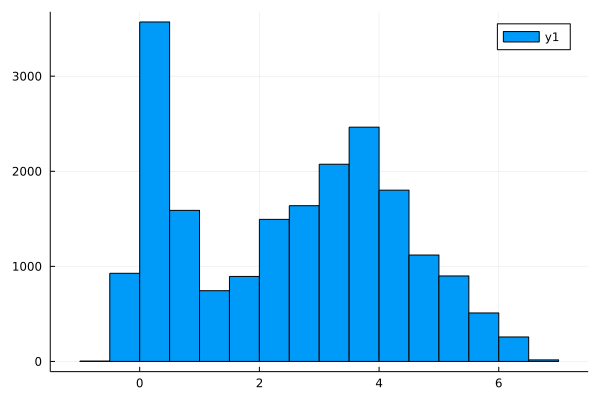

In [31]:
histogram(A[:, 1])

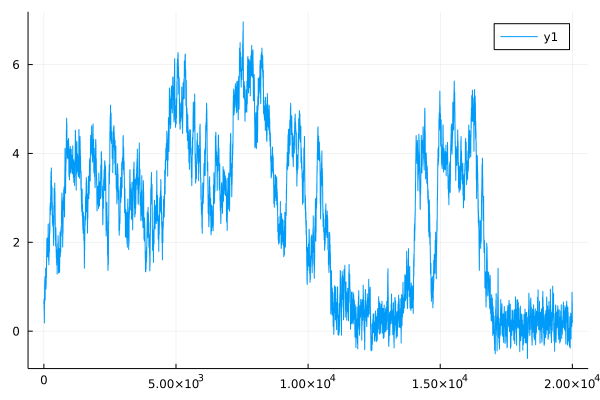

In [32]:
plot(1:num_iter, A[:, 1])